## Data Cleaning

Load the data `DASH_A1.csv` from the data folder.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/DASH_A1.csv")
df

,Date,Close,High,Low,Open,Volume
0,24-02-2022,100.419998,100.919998,85.177002,86.879997,6639000.0
1,01-08-2024,108.199997,112.769997,105.905998,108.620003,7965400.0
2,11-02-2025,193.089996,194.000000,189.500000,190.919998,6771900.0
3,13-04-2021,149.460007,150.360001,143.550003,146.839996,2823500.0
4,17-09-2024,129.880005,131.369995,126.900002,131.350006,2825500.0
...,...,...,...,...,...,...
1179,27-11-2024,178.440002,180.179993,177.699997,179.990005,2031100.0
1180,12-02-2025,200.889999,201.169998,195.197998,198.000000,9989400.0
1181,01-04-2025,182.419998,183.014999,178.259995,182.050003,3740700.0
1182,25-03-2024,137.820007,138.899994,136.740005,137.050003,2162800.0


We first set the "Date" as index. 

In [2]:
df["Date"] = pd.to_datetime(df["Date"], format = "%d-%m-%Y")

df.set_index("Date", inplace = True)
df

,Close,High,Low,Open,Volume
Date,,,,,
2022-02-24,100.419998,100.919998,85.177002,86.879997,6639000.0
2024-08-01,108.199997,112.769997,105.905998,108.620003,7965400.0
2025-02-11,193.089996,194.000000,189.500000,190.919998,6771900.0
2021-04-13,149.460007,150.360001,143.550003,146.839996,2823500.0
2024-09-17,129.880005,131.369995,126.900002,131.350006,2825500.0
...,...,...,...,...,...
2024-11-27,178.440002,180.179993,177.699997,179.990005,2031100.0
2025-02-12,200.889999,201.169998,195.197998,198.000000,9989400.0
2025-04-01,182.419998,183.014999,178.259995,182.050003,3740700.0


From the above data result, the data is not clean: 
- Dates out of order
- Duplicated rows
- Missing values

### Sorting the Index
It's important that the dataset is in ascending order. First, we check if the index is in ascending order. If the result gives a "False", then we sort the index into ascending order using sort_index


In [3]:
df.index.is_monotonic_increasing 

df.sort_index(inplace=True)

df.index.is_monotonic_increasing 

True

### Remove Duplicates
First, we check the total number of duplicated rows. If there any, remove those rows using drop_duplicates

In [4]:
df.duplicated().sum()

df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

### Missing values are categorised into: 
1. Open Prices
2. Close Prices
3. High and Low Prices
4. Volume (Zero Volume Condition)
5. Volume (Non-zero Volume Condition)

**NOTE:** When changing values in a data frame, it is recommended to avoid using `inplace`, and instead re-assign the variable.

#### 1. Open Prices
Because there are missing values in the Open Column, we want to clean the data based on the Firm Data Cleaning Rules: 

*"Missing values in the Open column are filled with the Close of
the day before as an approximation, ignoring overnight trading."*

Fill missing Open column by the value from the day before

In [5]:
df["Open"] = df["Open"].fillna(df["Close"].shift(1))

#### 2. Close Prices
Because there are missing values in the Close Column, we want to clean the data based on the Firm Data Cleaning Rules: 

*"Missing values in the Close column are forward-filled to avoid
look-ahead bias."*

Considering Forward-Filling means using the last known value to fill in the missing value, we take the previous Closing price

In [6]:
df["Close"] = df["Close"].ffill()

#### 3. High & Low Prices
Because there are missing values in the High & Low Column, we want to clean the data based on the Firm Data Cleaning Rules: 

*"Missing values in the High and Low columns are filled with the mean of the respective High or Low within that month."*

Fill missing High and Low value with the mean of respective High/Low value in that month.
By using `transform`, we apply a group-wise function while keeping the original shape/size of the data frame. 
We use `lambda` to simply write a function inline that is applied to each group. 

In [7]:
df["YearMonth"] = df.index.to_period("M")

df["High"] = df.groupby("YearMonth")["High"].transform(lambda x: x.fillna(x.mean()))
df["Low"] = df.groupby("YearMonth")["Low"].transform(lambda x: x.fillna(x.mean()))

df.drop(columns=["YearMonth"], inplace=True)

#### 4. Volume (Zero Volume Condition)
Because there are missing values in the Volume Column, we want to clean the data based on the Firm Data Cleaning Rules: 

*"If the Close price is equal to the Open price, the missing values in the Volume column are filled with zero, indicating no change in trading activity for the day."*
To do this, we first locate the Close price, then create a condition. 

In [8]:
df.loc[(df["Close"] == df["Open"]) & (df["Volume"].isna()), "Volume"] = 0

#### 5. Volume (Non-zero Volume Condition)
Because there are missing values in the Volume Column, we want to clean the data based on the Firm Data Cleaning Rules: 

*"Volume (Non-zero Volume Condition): If the Close Open price, the missing values in the Volume column are filled with the
median of the existing Volume values."*

Fill missing Volume value with the median of Volume value

In [9]:
df.loc[(df["Close"] != df["Open"]) & (df["Volume"].isna()), "Volume"] = df["Volume"].median()

### Final check to see if there's any missing values after cleaning
If result shows 0 (zero), then there's no missing values anymore

In [10]:
df.isnull().sum().sum()

np.int64(0)

#### Check data type before saving: Making sure Volume is integer
If the data in the Volume Column is in float, we change the type into integer

In [11]:
df.info()

df.Volume = df.Volume.astype("int64")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1134 entries, 2020-12-09 to 2025-06-13
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1134 non-null   float64
 1   High    1134 non-null   float64
 2   Low     1134 non-null   float64
 3   Open    1134 non-null   float64
 4   Volume  1134 non-null   float64
dtypes: float64(5)
memory usage: 53.2 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1134 entries, 2020-12-09 to 2025-06-13
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1134 non-null   float64
 1   High    1134 non-null   float64
 2   Low     1134 non-null   float64
 3   Open    1134 non-null   float64
 4   Volume  1134 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.2 KB


### Saving Data

To recap, we have done the data cleaning by: 
- Set the "Date" as index 
- Sort the index in ascending order
- Removing any duplicates
- Fill the missing values according to the Firm Data Cleaning Rules
- Change the Volume data type from float to integer

We can now save and import the cleaned data in csv. 

In [12]:
df.to_csv("DASH_A1_clean.csv")

## Feature engineering
### 1. Simple Daily Returns

We calculate the simple daily returns to measure the day-to-day percentage change in the stock's closing prices. This helps identify daily price movements as a percentage. 

In [13]:
df["SimpleReturns"] = df["Close"].pct_change()
df

,Close,High,Low,Open,Volume,SimpleReturns
Date,,,,,,
2020-12-09,189.509995,195.500000,163.800003,182.000000,25373700,NaN
2020-12-10,186.000000,187.695007,172.636002,179.710007,3506600,-0.018521
2020-12-11,175.000000,182.000000,168.250000,176.520004,4760600,-0.059140
2020-12-14,160.000000,170.000000,151.199997,169.100006,7859600,-0.085714
2020-12-15,158.889999,161.419998,153.759995,157.100006,5017000,-0.006938
...,...,...,...,...,...,...
2025-06-09,217.490005,219.830002,216.955002,218.029999,2710300,-0.004395
2025-06-10,214.970001,219.210007,210.927002,216.589996,3916700,-0.011587
2025-06-11,217.800003,219.529999,212.240005,214.184998,3091500,0.013165


### 2. Logarithmic Returns: 
We calculate the logarithmic returns using Close prices. Log returns are more useful than simple returns as they are additive across time. In contrast, simple returns need to be compounded.

In [14]:
df["LogReturns"] = np.log(1 + df["SimpleReturns"])
df

,Close,High,Low,Open,Volume,SimpleReturns,LogReturns
Date,,,,,,,
2020-12-09,189.509995,195.500000,163.800003,182.000000,25373700,NaN,NaN
2020-12-10,186.000000,187.695007,172.636002,179.710007,3506600,-0.018521,-0.018695
2020-12-11,175.000000,182.000000,168.250000,176.520004,4760600,-0.059140,-0.060961
2020-12-14,160.000000,170.000000,151.199997,169.100006,7859600,-0.085714,-0.089612
2020-12-15,158.889999,161.419998,153.759995,157.100006,5017000,-0.006938,-0.006962
...,...,...,...,...,...,...,...
2025-06-09,217.490005,219.830002,216.955002,218.029999,2710300,-0.004395,-0.004404
2025-06-10,214.970001,219.210007,210.927002,216.589996,3916700,-0.011587,-0.011654
2025-06-11,217.800003,219.529999,212.240005,214.184998,3091500,0.013165,0.013079


### 3. 20-Day Momentum:
To understand the short-term trend of the stock, we calculate the 20-day momentum. This is done by subtracting the closing price from 20 days ago from the current closing price. A positive value indicates upward trend, while a negative value suggests a downward trend.

In [15]:
df["Momentum_20"] = df.Close - df["Close"].shift(20)
df

,Close,High,Low,Open,Volume,SimpleReturns,LogReturns,Momentum_20
Date,,,,,,,,
2020-12-09,189.509995,195.500000,163.800003,182.000000,25373700,NaN,NaN,NaN
2020-12-10,186.000000,187.695007,172.636002,179.710007,3506600,-0.018521,-0.018695,NaN
2020-12-11,175.000000,182.000000,168.250000,176.520004,4760600,-0.059140,-0.060961,NaN
2020-12-14,160.000000,170.000000,151.199997,169.100006,7859600,-0.085714,-0.089612,NaN
2020-12-15,158.889999,161.419998,153.759995,157.100006,5017000,-0.006938,-0.006962,NaN
...,...,...,...,...,...,...,...,...
2025-06-09,217.490005,219.830002,216.955002,218.029999,2710300,-0.004395,-0.004404,33.970001
2025-06-10,214.970001,219.210007,210.927002,216.589996,3916700,-0.011587,-0.011654,22.869995
2025-06-11,217.800003,219.529999,212.240005,214.184998,3091500,0.013165,0.013079,20.000000


### 4. 20-Day Simple Moving Average:
We calculate the 20-day simple moving average of the stock's closing prices to smooth out short-term price fluctuations and better reflect long-term  trends. It works by averaging the closing prices over the previous 20 trading days, which smooth out daily noise and makes it easier to identify the stock  price direction over time.

In [16]:
df["Moving_Average_20"] = df["Close"].rolling(20).mean()
df

,Close,High,Low,Open,Volume,SimpleReturns,LogReturns,Momentum_20,Moving_Average_20
Date,,,,,,,,,
2020-12-09,189.509995,195.500000,163.800003,182.000000,25373700,NaN,NaN,NaN,NaN
2020-12-10,186.000000,187.695007,172.636002,179.710007,3506600,-0.018521,-0.018695,NaN,NaN
2020-12-11,175.000000,182.000000,168.250000,176.520004,4760600,-0.059140,-0.060961,NaN,NaN
2020-12-14,160.000000,170.000000,151.199997,169.100006,7859600,-0.085714,-0.089612,NaN,NaN
2020-12-15,158.889999,161.419998,153.759995,157.100006,5017000,-0.006938,-0.006962,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2025-06-09,217.490005,219.830002,216.955002,218.029999,2710300,-0.004395,-0.004404,33.970001,206.409998
2025-06-10,214.970001,219.210007,210.927002,216.589996,3916700,-0.011587,-0.011654,22.869995,207.553498
2025-06-11,217.800003,219.529999,212.240005,214.184998,3091500,0.013165,0.013079,20.000000,208.553498


### 5. 20-Day Rolling Volatility:
We calculate the 20-day rolling volatility to quantify the stock's price risk over time. Higher volatility indicates greater price unpredictability and investment risk, while lower volatility suggests more stable price.

In [17]:
df["Volatility_20"] = df["SimpleReturns"].rolling(20).std()
df

,Close,High,Low,Open,Volume,SimpleReturns,LogReturns,Momentum_20,Moving_Average_20,Volatility_20
Date,,,,,,,,,,
2020-12-09,189.509995,195.500000,163.800003,182.000000,25373700,NaN,NaN,NaN,NaN,NaN
2020-12-10,186.000000,187.695007,172.636002,179.710007,3506600,-0.018521,-0.018695,NaN,NaN,NaN
2020-12-11,175.000000,182.000000,168.250000,176.520004,4760600,-0.059140,-0.060961,NaN,NaN,NaN
2020-12-14,160.000000,170.000000,151.199997,169.100006,7859600,-0.085714,-0.089612,NaN,NaN,NaN
2020-12-15,158.889999,161.419998,153.759995,157.100006,5017000,-0.006938,-0.006962,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-06-09,217.490005,219.830002,216.955002,218.029999,2710300,-0.004395,-0.004404,33.970001,206.409998,0.017753
2025-06-10,214.970001,219.210007,210.927002,216.589996,3916700,-0.011587,-0.011654,22.869995,207.553498,0.015859
2025-06-11,217.800003,219.529999,212.240005,214.184998,3091500,0.013165,0.013079,20.000000,208.553498,0.014953


### 6. Day of the Week:
We identify the day of the week for each trading day (e.g., Monday, Tuesday, etc.) to enable time-based trend analysis. This can help detect weekday effects in stock returns, such as whether certain days typically yield higher or lower returns.

In [18]:
df["Day_Of_Week"] = df.index.day_name()
df


,Close,High,Low,Open,Volume,SimpleReturns,LogReturns,Momentum_20,Moving_Average_20,Volatility_20,Day_Of_Week
Date,,,,,,,,,,,
2020-12-09,189.509995,195.500000,163.800003,182.000000,25373700,NaN,NaN,NaN,NaN,NaN,Wednesday
2020-12-10,186.000000,187.695007,172.636002,179.710007,3506600,-0.018521,-0.018695,NaN,NaN,NaN,Thursday
2020-12-11,175.000000,182.000000,168.250000,176.520004,4760600,-0.059140,-0.060961,NaN,NaN,NaN,Friday
2020-12-14,160.000000,170.000000,151.199997,169.100006,7859600,-0.085714,-0.089612,NaN,NaN,NaN,Monday
2020-12-15,158.889999,161.419998,153.759995,157.100006,5017000,-0.006938,-0.006962,NaN,NaN,NaN,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-09,217.490005,219.830002,216.955002,218.029999,2710300,-0.004395,-0.004404,33.970001,206.409998,0.017753,Monday
2025-06-10,214.970001,219.210007,210.927002,216.589996,3916700,-0.011587,-0.011654,22.869995,207.553498,0.015859,Tuesday
2025-06-11,217.800003,219.529999,212.240005,214.184998,3091500,0.013165,0.013079,20.000000,208.553498,0.014953,Wednesday


### 7. Price Surge Identification:
We identify days when the price surge which is defined as days where the daily return is more than 4 standard deviations above the average return. This helps highlight unusually large price movements and outlier events in the data.



In [19]:
mean_return = df["SimpleReturns"].mean()
threshold = mean_return + df["SimpleReturns"].std() * 4
df["Price_Surge"] = df["SimpleReturns"] > threshold
df

,Close,High,Low,Open,Volume,SimpleReturns,LogReturns,Momentum_20,Moving_Average_20,Volatility_20,Day_Of_Week,Price_Surge
Date,,,,,,,,,,,,
2020-12-09,189.509995,195.500000,163.800003,182.000000,25373700,NaN,NaN,NaN,NaN,NaN,Wednesday,False
2020-12-10,186.000000,187.695007,172.636002,179.710007,3506600,-0.018521,-0.018695,NaN,NaN,NaN,Thursday,False
2020-12-11,175.000000,182.000000,168.250000,176.520004,4760600,-0.059140,-0.060961,NaN,NaN,NaN,Friday,False
2020-12-14,160.000000,170.000000,151.199997,169.100006,7859600,-0.085714,-0.089612,NaN,NaN,NaN,Monday,False
2020-12-15,158.889999,161.419998,153.759995,157.100006,5017000,-0.006938,-0.006962,NaN,NaN,NaN,Tuesday,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-09,217.490005,219.830002,216.955002,218.029999,2710300,-0.004395,-0.004404,33.970001,206.409998,0.017753,Monday,False
2025-06-10,214.970001,219.210007,210.927002,216.589996,3916700,-0.011587,-0.011654,22.869995,207.553498,0.015859,Tuesday,False
2025-06-11,217.800003,219.529999,212.240005,214.184998,3091500,0.013165,0.013079,20.000000,208.553498,0.014953,Wednesday,False


### 8. Volume Spike Identification:
We identify days when trading volume spiked  which is defined as days where the volume is more than 6 standard deviations above the average volume. This highlights unusually high trading activity that may signal significant market interest or news. 



In [20]:
mean_return = df["Volume"].mean()
threshold = mean_return + df["Volume"].std() * 6

df["Volume_Spike"] = df["Volume"] > threshold
df

,Close,High,Low,Open,Volume,SimpleReturns,LogReturns,Momentum_20,Moving_Average_20,Volatility_20,Day_Of_Week,Price_Surge,Volume_Spike
Date,,,,,,,,,,,,,
2020-12-09,189.509995,195.500000,163.800003,182.000000,25373700,NaN,NaN,NaN,NaN,NaN,Wednesday,False,False
2020-12-10,186.000000,187.695007,172.636002,179.710007,3506600,-0.018521,-0.018695,NaN,NaN,NaN,Thursday,False,False
2020-12-11,175.000000,182.000000,168.250000,176.520004,4760600,-0.059140,-0.060961,NaN,NaN,NaN,Friday,False,False
2020-12-14,160.000000,170.000000,151.199997,169.100006,7859600,-0.085714,-0.089612,NaN,NaN,NaN,Monday,False,False
2020-12-15,158.889999,161.419998,153.759995,157.100006,5017000,-0.006938,-0.006962,NaN,NaN,NaN,Tuesday,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-09,217.490005,219.830002,216.955002,218.029999,2710300,-0.004395,-0.004404,33.970001,206.409998,0.017753,Monday,False,False
2025-06-10,214.970001,219.210007,210.927002,216.589996,3916700,-0.011587,-0.011654,22.869995,207.553498,0.015859,Tuesday,False,False
2025-06-11,217.800003,219.529999,212.240005,214.184998,3091500,0.013165,0.013079,20.000000,208.553498,0.014953,Wednesday,False,False


### 9. Bollinger Bands Calculation:
We calculate the upper and lower Bollinger Bands for the stock. These bands are set 2 standard deviations above and below the 20-day simple moving average. The upper band is the resistance level while the lower band is the support. SMA above the upper band indicates the stock is overbought while SMA below the lower band indicates oversold

In [21]:
df["SMA"] = df["Close"].rolling(window=20).mean()
df["Dev"] = df["Close"].rolling(window=20).std()

df["UpperBand"] = df["SMA"] + 2 * df["Dev"]
df["LowerBand"] = df["SMA"]  - 2 * df["Dev"]

df


,Close,High,Low,Open,Volume,SimpleReturns,LogReturns,Momentum_20,Moving_Average_20,Volatility_20,Day_Of_Week,Price_Surge,Volume_Spike,SMA,Dev,UpperBand,LowerBand
Date,,,,,,,,,,,,,,,,,
2020-12-09,189.509995,195.500000,163.800003,182.000000,25373700,NaN,NaN,NaN,NaN,NaN,Wednesday,False,False,NaN,NaN,NaN,NaN
2020-12-10,186.000000,187.695007,172.636002,179.710007,3506600,-0.018521,-0.018695,NaN,NaN,NaN,Thursday,False,False,NaN,NaN,NaN,NaN
2020-12-11,175.000000,182.000000,168.250000,176.520004,4760600,-0.059140,-0.060961,NaN,NaN,NaN,Friday,False,False,NaN,NaN,NaN,NaN
2020-12-14,160.000000,170.000000,151.199997,169.100006,7859600,-0.085714,-0.089612,NaN,NaN,NaN,Monday,False,False,NaN,NaN,NaN,NaN
2020-12-15,158.889999,161.419998,153.759995,157.100006,5017000,-0.006938,-0.006962,NaN,NaN,NaN,Tuesday,False,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-09,217.490005,219.830002,216.955002,218.029999,2710300,-0.004395,-0.004404,33.970001,206.409998,0.017753,Monday,False,False,206.409998,7.886279,222.182556,190.637440
2025-06-10,214.970001,219.210007,210.927002,216.589996,3916700,-0.011587,-0.011654,22.869995,207.553498,0.015859,Tuesday,False,False,207.553498,7.341377,222.236252,192.870744
2025-06-11,217.800003,219.529999,212.240005,214.184998,3091500,0.013165,0.013079,20.000000,208.553498,0.014953,Wednesday,False,False,208.553498,7.304940,223.163377,193.943619


## Key Dates
### 1. Highest Volatility Day
We add a new column "Year" to the dataframe and index it. Then we remove all rows with missing NaN. After that, we groups the data by year and find the index of the row with the maximum volatility in each year. 

In [22]:
df['Year'] = df.index.year

vol = df.dropna(subset=['Volatility_20'])

vol_max = vol.groupby("Year")['Volatility_20'].idxmax()
highest_vol = df.loc[vol_max,['Year','Volatility_20']]

print("\nHighest Volatility Day:\n",highest_vol)



Highest Volatility Day:
             Year  Volatility_20
Date                           
2021-05-20  2021       0.067393
2022-06-01  2022       0.080994
2023-11-06  2023       0.047470
2024-02-27  2024       0.033547
2025-04-10  2025       0.048324


### 2.  Largest Price Surge Day: 
Find the date and value of the largest price surge in each year. This is determined by the greatest positive daily return.

In [23]:
ret = df.dropna(subset=["SimpleReturns"])

surge_max = ret.groupby("Year")["SimpleReturns"].idxmax()
highest_surge = df.loc[surge_max, ["Year", "SimpleReturns"]]

print("\nLargest Price Surge Day:\n",highest_surge)


Largest Price Surge Day:
             Year  SimpleReturns
Date                           
2020-12-18  2020       0.078724
2021-05-14  2021       0.221491
2022-03-16  2022       0.134512
2023-11-02  2023       0.156653
2024-08-02  2024       0.083457
2025-04-09  2025       0.137738


### 3. Largest Price Drop Day: 
Find the date and value of the largest price drop in each year. This is determined by the greatest negative daily return.

In [24]:
drop = ret.groupby("Year")["SimpleReturns"].idxmin()
largest_drop = df.loc[drop, ["Year", "SimpleReturns"]]

print("\nLargest Price Drop Day:\n",largest_drop)


Largest Price Drop Day:
             Year  SimpleReturns
Date                           
2020-12-14  2020      -0.085714
2021-02-22  2021      -0.135457
2022-05-11  2022      -0.131621
2023-02-17  2023      -0.075946
2024-05-02  2024      -0.103170
2025-04-03  2025      -0.080634


### 4. Highest Volume Day: 
Find the date and value of the greatest trading volume in each year. This is determined by the highest volume recorded within the year.

In [25]:
vol_idx = df.groupby("Year")["Volume"].idxmax()
highest_volume = df.loc[vol_idx, ["Year", "Volume"]]

print("\nHighest Volume Day:\n",highest_volume)


Highest Volume Day:
             Year    Volume
Date                      
2020-12-09  2020  25373700
2021-03-09  2021  20400000
2022-02-17  2022  47405700
2023-12-15  2023  30556000
2024-05-02  2024  22134800
2025-03-21  2025  73637400


### 5. Highest High and Lowest Low: 
Find the the date and value for both the highest high and lowest low, within each year.

In [26]:
high_idx = df.groupby("Year")["High"].idxmax()
highest_high = df.loc[high_idx, ["Year", "High"]]

low_idx = df.groupby("Year")["Low"].idxmin()
lowest_low = df.loc[low_idx, ["Year", "Low"]]

print("\nHighest High:\n",highest_high)
print("\nLowest Low:\n",lowest_low)


Highest High:
             Year        High
Date                        
2020-12-09  2020  195.500000
2021-11-15  2021  257.250000
2022-01-12  2022  152.494995
2023-12-11  2023  103.980003
2024-12-17  2024  181.779999
2025-06-06  2025  220.880005

Lowest Low:
             Year         Low
Date                        
2020-12-31  2020  135.380005
2021-05-13  2021  110.129997
2022-10-24  2022   41.365002
2023-01-06  2023   45.931999
2024-01-04  2024   93.330002
2025-04-07  2025  155.399994


### 6. Annual Open and Close: 
Find the open price at the start of each year, and the close price at the end of each year. It is not necessary to capture the dates for this criteria. 

In [27]:
print("Annual Open:\n", df.groupby('Year').first()[['Open']])
print("\nAnnual Close:\n", df.groupby('Year').last()[['Close']])

Annual Open:
             Open
Year            
2020  182.000000
2021  142.500000
2022  149.610001
2023   49.980000
2024   97.800003
2025  168.789993

Annual Close:
            Close
Year            
2020  142.750000
2021  148.899994
2022   48.820000
2023   98.889999
2024  167.750000
2025  218.119995


## Visualisation
### Bollinger on DASH
To analyse the volatility and price behaviour of the asset, we plotted the Bollinger Bands alongside the Simple Moving Average. To analyse market activity and price dynamics, subplots were created to show the historical volume and volatility.

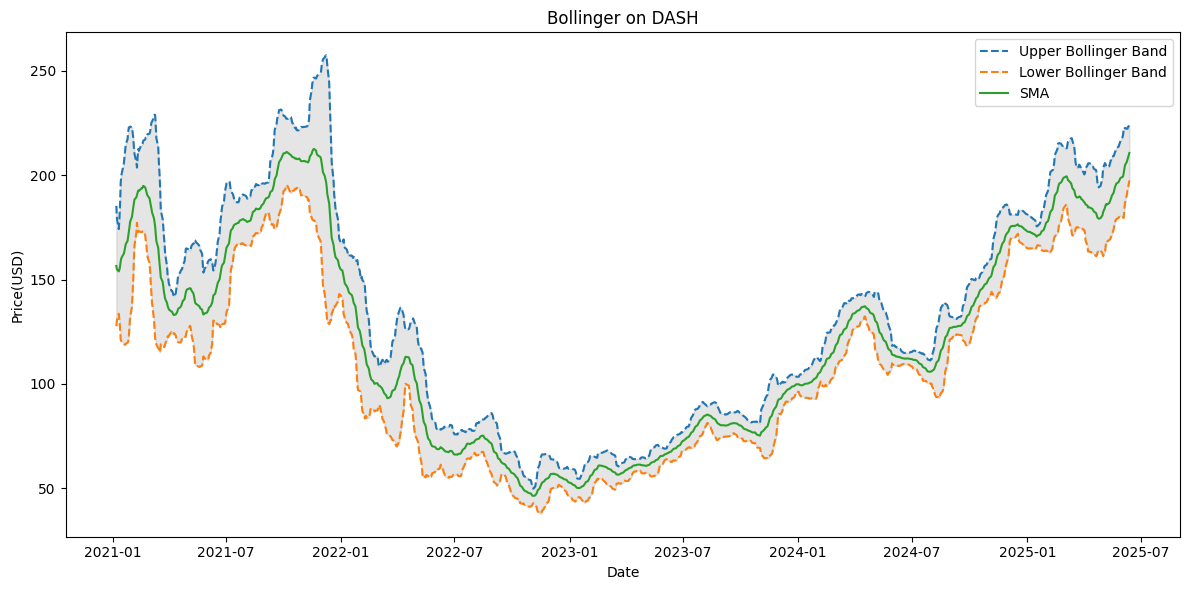

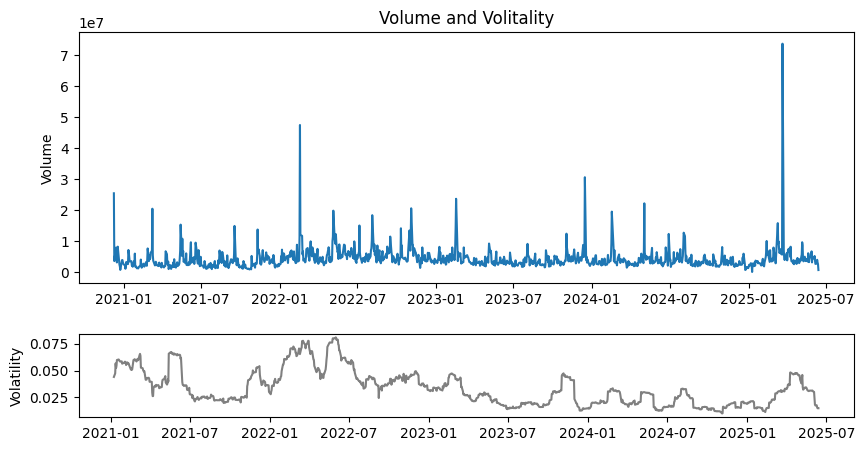

In [ ]:
# Mainplot
plt.figure(figsize=(12,6))
plt.title("Bollinger on DASH")
plt.xlabel("Date")
plt.ylabel("Price(USD)")

plt.plot(df.UpperBand, label="Upper Bollinger Band", linestyle="--")
plt.plot(df.LowerBand, label="Lower Bollinger Band", linestyle="--")
plt.fill_between(df.index, df.UpperBand, df.LowerBand, color="grey", alpha=0.2)
plt.plot(df.SMA, label="SMA")

plt.legend()
plt.tight_layout()
plt.show()

# Subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,5), gridspec_kw={"height_ratios": [3, 1]})
fig.subplots_adjust(hspace=0.3)

# Plot the first subplot
ax1.plot(df.index, df["Volume"], label="Volume")
ax1.set_title("Volume and Volitality")
ax1.set_ylabel("Volume")

# Plot the second subplot
ax2.plot(df.index, df["Volatility_20"], label="Volume", color="grey")
ax2.set_ylabel("Volatility")
plt.show()


### Histogram of Log Returns
A histogram of the historical log returns can help us visualise the correlation between daily returns and frequency distribution, the middle part is the normal distribution of returns, where the outliers and tails represents potential downside risk.

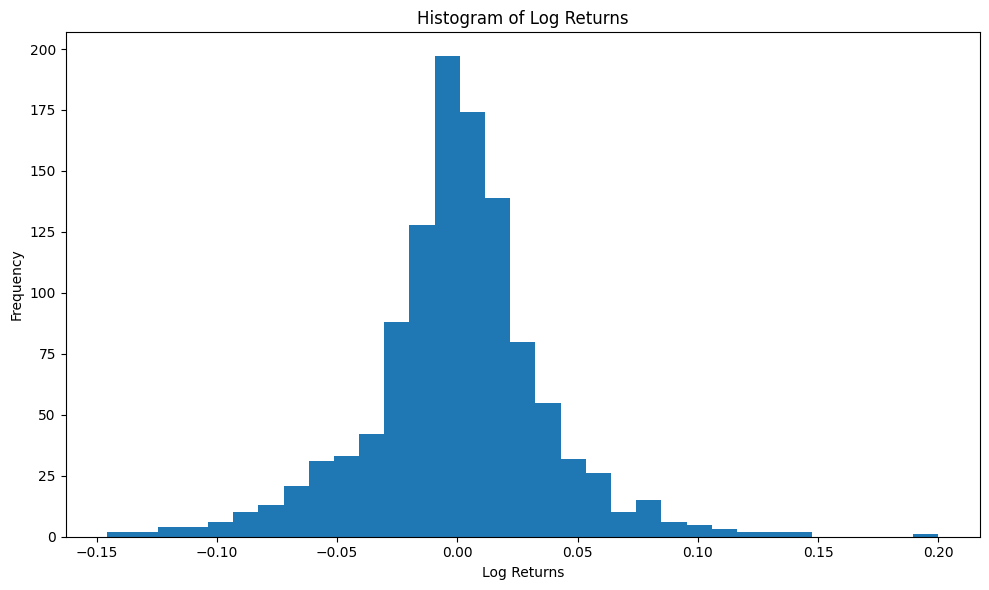

In [ ]:
recommended_bins = int(np.sqrt(len(df.LogReturns)))
recommended_bins

plt.figure(figsize=(10, 6))
plt.hist(df.LogReturns, bins=recommended_bins)
plt.title("Histogram of Log Returns")
plt.ylabel("Frequency")
plt.xlabel("Log Returns")
plt.tight_layout() 


### Scatter Plot 


A scatter chart using daily log returns and volume over time can gives us an idea of the correlation between the trading activity and price volatility.
Through analysing the graph, we can conclude that high trading volume often aligns with larger price movements, potentially due to the market reacting to news or events.
While lower volume suggests stability.

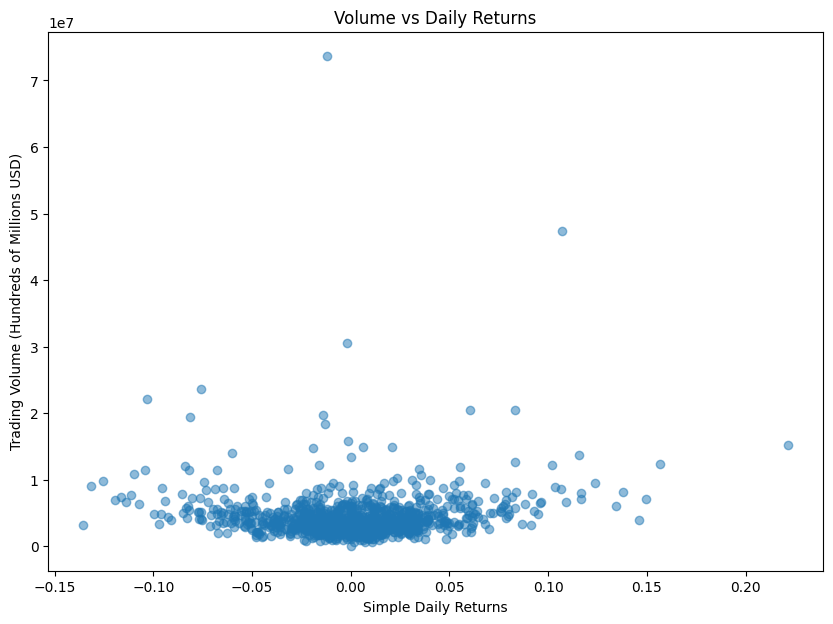

In [30]:
plt.figure(figsize=(10, 7))
plt.scatter(df.SimpleReturns, df.Volume, alpha=0.5)
plt.title("Volume vs Daily Returns")
plt.ylabel("Trading Volume (Hundreds of Millions USD)")
plt.xlabel("Simple Daily Returns")
plt.show()

# Reporting